Importing Dataset




In [1]:
from datasets import load_dataset

try:
    # Load the PubMedQA dataset
    dataset = load_dataset("pubmed_qa", "pqa_labeled")
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded successfully!


In [4]:
data_list = []

# Safely iterate through dataset
for item in dataset["train"]:
    try:
        q = item.get("question", "")
        ctx = item.get("context", "")
        ans = item.get("final_decision", "")

        data_list.append({
            "question": q,
            "context": ctx,
            "answer": ans
        })
    except Exception as e:
        print("Skipping item due to error:", e)


In [5]:
import pandas as pd
df = pd.DataFrame(data_list)
df.head()

,question,context,answer
0,Do mitochondria play a role in remodelling lac...,{'contexts': ['Programmed cell death (PCD) is ...,yes
1,Landolt C and snellen e acuity: differences in...,{'contexts': ['Assessment of visual acuity dep...,no
2,"Syncope during bathing in infants, a pediatric...",{'contexts': ['Apparent life-threatening event...,yes
3,Are the long-term results of the transanal pul...,{'contexts': ['The transanal endorectal pull-t...,no
4,Can tailored interventions increase mammograph...,{'contexts': ['Telephone counseling and tailor...,yes


Normalizing Text

In [6]:
def extract_context_text(context_entry):
    """
    Works for entries like:
    {'contexts': ['text1', 'text2', ...]}
    """
    if isinstance(context_entry, dict) and "contexts" in context_entry:
        ctx = context_entry["contexts"]
        if isinstance(ctx, list):
            return " ".join(ctx)
        return str(ctx)

    elif isinstance(context_entry, list):
        return " ".join(context_entry)

    return str(context_entry)


In [7]:
df['context_text'] = df['context'].apply(extract_context_text)  # flatten dict/list to text
df['answer_label'] = df['answer'].astype(str).str.strip().str.lower().map(lambda x: 'yes' if x.startswith('y') else 'no')

In [8]:

print(df[['question','answer_label']].head())
print(df['answer_label'].value_counts())

                                            question answer_label
0  Do mitochondria play a role in remodelling lac...          yes
1  Landolt C and snellen e acuity: differences in...           no
2  Syncope during bathing in infants, a pediatric...          yes
3  Are the long-term results of the transanal pul...           no
4  Can tailored interventions increase mammograph...          yes
answer_label
yes    552
no     448
Name: count, dtype: int64


In [9]:
import pandas as pd

# example: df.head() looked like the snippet you pasted; identify columns
print(df.columns)
# try to standardize:
if 'answer_label' in df.columns:
    df = df.rename(columns={'answer_label':'label'})

# choose text column adapt names as necessary
if 'question' not in df.columns:
    # maybe there is a 'text' or 'title' + 'abstract' etc.
    if 'text' in df.columns:
        df['context'] = df['text']
    elif 'title' in df.columns and 'abstract' in df.columns:
        df['context'] = (df['title'].fillna('') + ' ' + df['abstract'].fillna('')).str.strip()
    else:
        raise ValueError("Please set or rename your text column to 'context' or 'question'")

# unify labels
df['label'] = df['label'].astype(str).str.strip().str.lower().map(lambda x: 'yes' if x.startswith('y') else ('no' if x.startswith('n') else x))
print(df['label'].value_counts())


Index(['question', 'context', 'answer', 'context_text', 'answer_label'], dtype='object')
label
yes    552
no     448
Name: count, dtype: int64


In [10]:
# check columns
print(df.columns)

# rename columns if needed
# assuming the second column is the label
if 'answer_label' not in df.columns:
    if 'answer' in df.columns:
        df['answer_label'] = df['answer'].astype(str).str.strip().str.lower().map(lambda x: 'yes' if x.startswith('y') else 'no')
    else:
        # fallback: second column
        label_col = df.columns[1]
        df['answer_label'] = df[label_col].astype(str).str.strip().str.lower().map(lambda x: 'yes' if x.startswith('y') else 'no')

# ensure question column exists
if 'question' not in df.columns:
    df['question'] = df[df.columns[0]].astype(str)


Index(['question', 'context', 'answer', 'context_text', 'label'], dtype='object')


Testing and Training Split

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['answer_label'])

# Convert to list of dicts for easier looping
train_examples = [{"question": q, "answer": a} for q, a in zip(train_df['question'], train_df['answer_label'])]
test_examples = [{"question": q, "answer": a} for q, a in zip(test_df['question'], test_df['answer_label'])]

print("Train examples:", len(train_examples))
print("Test examples:", len(test_examples))


Train examples: 800
Test examples: 200


Chucking into passages

In [12]:
import re

def clean_text(s):
    return re.sub(r'\s+', ' ', str(s)).strip()

def chunk_text(text, size=400, stride=150):
    t = clean_text(text)
    if len(t) <= size:
        return [t]
    chunks=[]
    i=0
    while i < len(t):
        chunks.append(t[i:i+size])
        if i+size >= len(t): break
        i += size - stride
    return chunks

# Build passages for all train examples
passages=[]
meta=[]
for idx, row in train_df.reset_index().iterrows():
    cs = chunk_text(row['question'], size=400, stride=150)
    for c in cs:
        passages.append(c)
        meta.append({'source_idx': idx, 'label': row['answer_label']})

print("Total passages:", len(passages))


Total passages: 800


Embeddings + FAISS

In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

embed_model = "all-MiniLM-L6-v2"  # or Bio/clinical embedding
embedder = SentenceTransformer(embed_model)

# Embed passages
batch_size = 64
embs = []
for i in range(0, len(passages), batch_size):
    batch = passages[i:i+batch_size]
    emb = embedder.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    embs.append(emb)
passage_emb = np.vstack(embs).astype('float32')

# FAISS index
faiss.normalize_L2(passage_emb)
d = passage_emb.shape[1]
index = faiss.IndexFlatIP(d)
index.add(passage_emb)
print("Index size:", index.ntotal)


Index size: 800


Retrieval + Prompt

In [14]:
def retrieve_topk(question, k=5):
    q_emb = embedder.encode([question], convert_to_numpy=True).astype('float32')
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, k)
    ids = [int(i) for i in I[0]]  # flat list of integers
    return ids

PROMPT = """You are given a question and supporting context. Answer with ONLY one word: "yes" or "no".

Question:
{q}

Context:
{ctx}

Answer (only 'yes' or 'no'):"""

def make_prompt(question, passage_ids):
    ctx = "\n\n".join([passages[i] for i in passage_ids])
    return PROMPT.format(q=question, ctx=ctx)


Load multiple small public LLMs

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline

# Define your models
MODEL_IDS = {
    "flan": "google/flan-t5-small",       # seq2seq
    "bloomz": "bigscience/bloomz-560m",   # causal LM
    "t5": "t5-small"                       # seq2seq
}

SEQ2SEQ_MODELS = ["flan", "t5"]  # seq2seq
LOCAL_PIPELINES = {}

def load_pipeline(model_key):
    if model_key in LOCAL_PIPELINES:
        return LOCAL_PIPELINES[model_key]

    model_id = MODEL_IDS[model_key]
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    if model_key in SEQ2SEQ_MODELS:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
        pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_id)
        pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

    LOCAL_PIPELINES[model_key] = pipe
    return pipe


RAG inference

In [19]:
def to_yesno(text):
    t = str(text).strip().lower()
    if t.startswith("yes"): return "yes"
    if t.startswith("no"): return "no"
    for token in t.replace("."," ").replace(","," ").split():
        if token in ("yes","no"): return token
    return "yes"

def rag_predict(question, model_key, k=5, max_new_tokens=64):
    passage_ids = retrieve_topk(question, k)
    prompt = make_prompt(question, passage_ids)
    pipeline_obj = load_pipeline(model_key)
    out = pipeline_obj(prompt, max_new_tokens=max_new_tokens)
    raw = out[0].get("generated_text", out[0].get("text","")) if isinstance(out,list) else str(out)
    pred = to_yesno(raw)
    return pred, raw


Evaluate all 3 public small models

In [20]:
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json

def evaluate_models(model_keys, examples, k=5, max_new_tokens=64):
    summary = {}
    for mk in model_keys:
        print("\nEvaluating:", mk)
        preds, truths = [], []
        for ex in examples:
            pred,_ = rag_predict(ex["question"], mk, k, max_new_tokens)
            preds.append(pred)
            truths.append(ex["answer"])
        acc = accuracy_score(truths, preds)
        p,r,f1,_ = precision_recall_fscore_support(truths, preds, average='binary', pos_label='yes', zero_division=0)
        summary[mk] = {"accuracy":acc, "precision":p, "recall":r, "f1":f1}
        print(mk, summary[mk])
    with open("rag_model_comparison_results.json","w") as f:
        json.dump(summary,f,indent=2)
    return summary

results = evaluate_models(["flan","bloomz","t5"], test_examples, k=5, max_new_tokens=64)
print("\nFinal comparison:\n", json.dumps(results, indent=2))



Evaluating: flan


Device set to use cpu


flan {'accuracy': 0.45, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Evaluating: bloomz


Device set to use cpu


bloomz {'accuracy': 0.56, 'precision': 0.5670731707317073, 'recall': 0.8454545454545455, 'f1': 0.6788321167883211}

Evaluating: t5


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


t5 {'accuracy': 0.55, 'precision': 0.55, 'recall': 1.0, 'f1': 0.7096774193548387}

Final comparison:
 {
  "flan": {
    "accuracy": 0.45,
    "precision": 0.0,
    "recall": 0.0,
    "f1": 0.0
  },
  "bloomz": {
    "accuracy": 0.56,
    "precision": 0.5670731707317073,
    "recall": 0.8454545454545455,
    "f1": 0.6788321167883211
  },
  "t5": {
    "accuracy": 0.55,
    "precision": 0.55,
    "recall": 1.0,
    "f1": 0.7096774193548387
  }
}


Plotting Performance of 3 LLMs

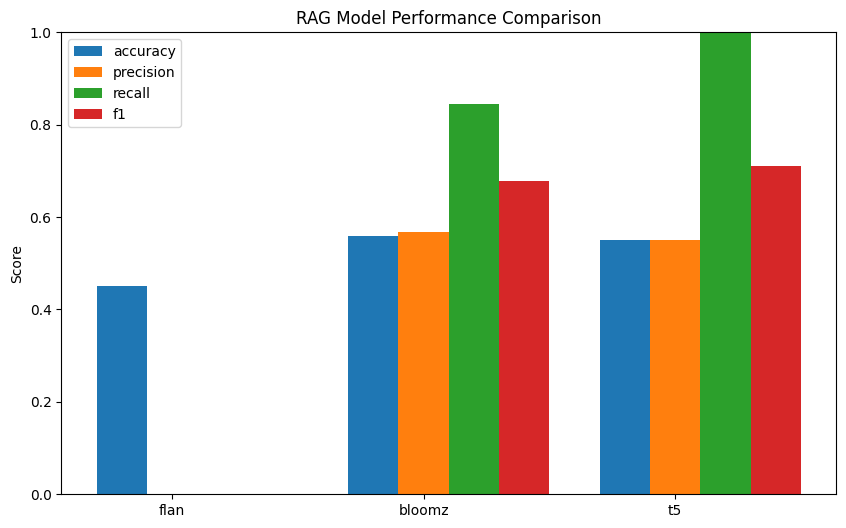

In [26]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "precision", "recall", "f1"]
models = list(results.keys())

# Prepare data for plotting
data = {metric: [results[m][metric] for m in models] for metric in metrics}

# Plot grouped bar chart
x = range(len(models))
width = 0.2

plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics):
    plt.bar([p + i*width for p in x], data[metric], width=width, label=metric)

plt.xticks([p + 1.0*width for p in x], models)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("RAG Model Performance Comparison")
plt.legend()
plt.show()


Some Examples of Questions

In [21]:
# Ask your question here
your_question = "Do mitochondria play a role in remodeling lacrimal glands?"

# Number of top passages to retrieve
TOP_K = 5
MAX_NEW_TOKENS = 64

for model_key in ["flan", "bloomz", "t5"]:
    pred, raw_output = rag_predict(your_question, model_key, k=TOP_K, max_new_tokens=MAX_NEW_TOKENS)
    print(f"Model: {model_key}")
    print(f"Predicted answer: {pred}")
    print(f"Raw output: {raw_output}")
    print("-"*50)


Model: flan
Predicted answer: no
Raw output: no
--------------------------------------------------
Model: bloomz
Predicted answer: yes
Raw output: You are given a question and supporting context. Answer with ONLY one word: "yes" or "no".

Question:
Do mitochondria play a role in remodeling lacrimal glands?

Context:
Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?

Juvenile osteochondritis dissecans: is it a growth disturbance of the secondary physis of the epiphysis?

Chemical shift MRI: is there any contribution to morphologic evaluation of solid breast masses?

Can nonproliferative breast disease and proliferative breast disease without atypia be distinguished by fine-needle aspiration cytology?

Is breast cancer survival improving?

Answer (only 'yes' or 'no'): Yes
--------------------------------------------------
Model: t5
Predicted answer: yes
Raw output: Answer with ONLY one word: "yes" or "no". Question: Do mitochondria play a role in 

In [22]:
# Ask your question here
your_question = "Can early physical therapy prevent joint stiffness after knee replacement surgery?"

# Number of top passages to retrieve
TOP_K = 5
MAX_NEW_TOKENS = 64

for model_key in ["flan", "bloomz", "t5"]:
    pred, raw_output = rag_predict(your_question, model_key, k=TOP_K, max_new_tokens=MAX_NEW_TOKENS)
    print(f"Model: {model_key}")
    print(f"Predicted answer: {pred}")
    print(f"Raw output: {raw_output}")
    print("-"*50)


Model: flan
Predicted answer: no
Raw output: no
--------------------------------------------------
Model: bloomz
Predicted answer: yes
Raw output: You are given a question and supporting context. Answer with ONLY one word: "yes" or "no".

Question:
Can early physical therapy prevent joint stiffness after knee replacement surgery?

Context:
Can normal knee kinematics be restored with unicompartmental knee replacement?

Does anterior laxity of the uninjured knee influence clinical outcomes of ACL reconstruction?

Is bicompartmental knee arthroplasty more favourable to knee muscle strength and physical performance compared to total knee arthroplasty?

Does patella position influence ligament balancing in total knee arthroplasty?

Should lower limb fractures be treated surgically in patients with chronic spinal injuries?

Answer (only 'yes' or 'no'): Yes
--------------------------------------------------
Model: t5
Predicted answer: yes
Raw output: Answer with ONLY one word: "yes" or "no". 

In [24]:
# Ask your question here
your_question = "Does the use of statins reduce mortality in patients with sepsis?"

# Number of top passages to retrieve
TOP_K = 5
MAX_NEW_TOKENS = 64

for model_key in ["flan", "bloomz", "t5"]:
    pred, raw_output = rag_predict(your_question, model_key, k=TOP_K, max_new_tokens=MAX_NEW_TOKENS)
    print(f"Model: {model_key}")
    print(f"Predicted answer: {pred}")
    print(f"Raw output: {raw_output}")
    print("-"*50)


Model: flan
Predicted answer: no
Raw output: no
--------------------------------------------------
Model: bloomz
Predicted answer: yes
Raw output: You are given a question and supporting context. Answer with ONLY one word: "yes" or "no".

Question:
Does the use of statins reduce mortality in patients with sepsis?

Context:
Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?

Is inhaled prophylactic heparin useful for prevention and Management of Pneumonia in ventilated ICU patients?

Is the zeolite hemostatic agent beneficial in reducing blood loss during arterial injury?

Does the leukocyte count correlate with the severity of injury?

Are interstitial fluid concentrations of meropenem equivalent to plasma concentrations in critically ill patients receiving continuous renal replacement therapy?

Answer (only 'yes' or 'no'): Yes
--------------------------------------------------
Model: t5
Predicted answer: yes
Raw output: Answer with ONLY one word: